In [1]:
!pip install -q transformers wandb

In [2]:
import wandb
wandb.login()

wandb: Currently logged in as: katrinpochtar to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
import gc
import json
import random
import warnings
from functools import partial
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torchaudio
from torch.amp import GradScaler, autocast
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from transformers import (
    Wav2Vec2ForSequenceClassification,
    HubertForSequenceClassification,
    Wav2Vec2FeatureExtractor,
    AutoImageProcessor,
    TimesformerForVideoClassification,
)

warnings.filterwarnings("ignore")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
METADATA = "/content/processed_data/metadata.json"
OUT_DIR = Path("/content/trained_encoders_v2")
OUT_DIR.mkdir(parents=True, exist_ok=True)

EXCLUDE = {0, 7}
REMAP = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}
EMOTIONS = ["calm", "happy", "sad", "angry", "fearful", "disgust"]
NUM_EMOTIONS = len(EMOTIONS)
LABEL_SMOOTHING = 0.1

print(f"Device: {DEVICE}, Classes: {NUM_EMOTIONS}, Emotions: {EMOTIONS}")

Device: cuda, Classes: 6, Emotions: ['calm', 'happy', 'sad', 'angry', 'fearful', 'disgust']


In [4]:
class EmotionDataset(Dataset):
    def __init__(self, metadata_path, split, modality):
        with open(metadata_path) as f:
            data = json.load(f)
        self.samples = [s for s in data
                        if s["split"] == split and s["emotion_idx"] not in EXCLUDE]
        self.modality = modality

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]
        item = {"emotion": REMAP[s["emotion_idx"]]}
        if self.modality == "audio":
            wav, _ = torchaudio.load(s["audio_path"])
            item["audio"] = wav.squeeze(0)
        else:
            frames = np.load(s["frames_path"])
            item["video"] = torch.from_numpy(frames).permute(0, 3, 1, 2).float() / 255.0
        return item


def collate_fn(batch):
    out = {"emotion": torch.tensor([b["emotion"] for b in batch])}
    if "audio" in batch[0]:
        out["audio"] = [b["audio"] for b in batch]
    if "video" in batch[0]:
        out["video"] = torch.stack([b["video"] for b in batch])
    return out

In [5]:
def crop_audio(wav, sr, duration, train):
    L = int(round(duration * sr))
    n = wav.numel()
    if n <= L:
        return torch.nn.functional.pad(wav, (0, L - n))
    start = torch.randint(0, n - L + 1, ()).item() if train else (n - L) // 2
    return wav[start:start + L]


def crop_video(video, n_frames, train):
    T = video.shape[0]
    if T <= n_frames:
        idx = torch.linspace(0, T - 1, n_frames).round().long()
        return video[idx]
    start = torch.randint(0, T - n_frames + 1, ()).item() if train else (T - n_frames) // 2
    return video[start:start + n_frames]


def prepare_audio(batch, processor, window_s, device, train=True):
    sr = 16000
    wavs = [crop_audio(a, sr, window_s, train).numpy() for a in batch["audio"]]
    enc = processor(wavs, sampling_rate=sr, return_tensors="pt", padding=True,
                    truncation=True, max_length=int(window_s * sr))
    kwargs = {"input_values": enc["input_values"].to(device)}
    if "attention_mask" in enc:
        kwargs["attention_mask"] = enc["attention_mask"].to(device)
    return kwargs, batch["emotion"].to(device)


def prepare_video(batch, processor, n_frames, device, train=True):
    clips = []
    for v in batch["video"]:
        clip = crop_video(v, n_frames, train)
        clips.append([clip[i].permute(1, 2, 0).numpy() for i in range(clip.shape[0])])
    enc = processor(clips, return_tensors="pt", do_rescale=False)
    return {"pixel_values": enc["pixel_values"].to(device)}, batch["emotion"].to(device)

In [6]:
def train_one_epoch(model, loader, prep_fn, optimizer, scaler, loss_fn):
    model.train()
    total_loss, preds, labels = 0.0, [], []
    for batch in tqdm(loader, leave=False):
        kwargs, y = prep_fn(batch, train=True)
        optimizer.zero_grad(set_to_none=True)
        with autocast("cuda", enabled=DEVICE == "cuda"):
            logits = model(**kwargs).logits
            loss = loss_fn(logits, y)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
        preds.extend(logits.argmax(1).detach().cpu().tolist())
        labels.extend(y.cpu().tolist())
    return {
        "loss": total_loss / len(loader),
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
    }


@torch.no_grad()
def evaluate(model, loader, prep_fn, loss_fn):
    model.eval()
    total_loss, preds, labels = 0.0, [], []
    for batch in tqdm(loader, leave=False):
        kwargs, y = prep_fn(batch, train=False)
        with autocast("cuda", enabled=DEVICE == "cuda"):
            logits = model(**kwargs).logits
            loss = loss_fn(logits, y)
        total_loss += loss.item()
        preds.extend(logits.argmax(1).cpu().tolist())
        labels.extend(y.cpu().tolist())
    return {
        "loss": total_loss / len(loader),
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
    }

In [7]:
def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def run_experiment(cfg):
    seed_all()
    name, modality = cfg["name"], cfg["modality"]
    print(f"{'='*60}\n{name}\n{'='*60}")

    wandb.init(project="uncanny-valley-encoders-v2", name=name,
               group=modality, config=cfg, reinit=True)

    train_ds = EmotionDataset(METADATA, "train", modality)
    val_ds = EmotionDataset(METADATA, "val", modality)
    bs = cfg.get("batch_size", 8)
    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True,
                              num_workers=0, collate_fn=collate_fn)
    val_loader = DataLoader(val_ds, batch_size=bs, shuffle=False,
                            num_workers=0, collate_fn=collate_fn)

    if modality == "audio":
        model_cls = (HubertForSequenceClassification if "hubert" in cfg["model"].lower()
                     else Wav2Vec2ForSequenceClassification)
        model = model_cls.from_pretrained(
            cfg["model"], num_labels=NUM_EMOTIONS, ignore_mismatched_sizes=True)
        processor = Wav2Vec2FeatureExtractor.from_pretrained(cfg["model"])
        prep_fn = partial(prepare_audio, processor=processor,
                          window_s=cfg.get("window_s", 3.0), device=DEVICE)
        if hasattr(model, "freeze_feature_encoder"):
            model.freeze_feature_encoder()
    else:
        model = TimesformerForVideoClassification.from_pretrained(
            cfg["model"], num_labels=NUM_EMOTIONS, ignore_mismatched_sizes=True)
        processor = AutoImageProcessor.from_pretrained(cfg["model"])
        prep_fn = partial(prepare_video, processor=processor,
                          n_frames=cfg.get("n_frames", 8), device=DEVICE)
        for n, p in model.named_parameters():
            if "classifier" not in n:
                p.requires_grad = False

    model.to(DEVICE)
    loss_fn = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
    optimizer = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()), lr=cfg["lr"])
    scaler = GradScaler(enabled=DEVICE == "cuda")
    scheduler = None

    best_f1, patience_cnt = 0.0, 0
    save_path = OUT_DIR / name

    for epoch in range(cfg["epochs"]):
        freeze_ep = cfg.get("freeze_epochs", 2)
        if epoch == freeze_ep:
            for p in model.parameters():
                p.requires_grad = True
            unfreeze_lr = cfg["lr"] if freeze_ep == 0 else cfg["lr"] * 0.1
            optimizer = torch.optim.AdamW(model.parameters(), lr=unfreeze_lr)
            scaler = GradScaler(enabled=DEVICE == "cuda")
            scheduler = CosineAnnealingLR(
                optimizer, T_max=cfg["epochs"] - epoch, eta_min=1e-7)

        t = train_one_epoch(model, train_loader, prep_fn, optimizer, scaler, loss_fn)
        v = evaluate(model, val_loader, prep_fn, loss_fn)

        if scheduler:
            scheduler.step()

        wandb.log({
            "epoch": epoch + 1,
            "train/loss": t["loss"], "train/acc": t["acc"], "train/f1": t["f1"],
            "val/loss": v["loss"], "val/acc": v["acc"], "val/f1": v["f1"],
            "lr": optimizer.param_groups[0]["lr"],
        })
        print(f"  [{epoch+1:2d}/{cfg['epochs']}] "
              f"t_f1={t['f1']:.3f} v_f1={v['f1']:.3f} v_loss={v['loss']:.3f}")

        if v["f1"] > best_f1:
            best_f1 = v["f1"]
            save_path.mkdir(parents=True, exist_ok=True)
            model.save_pretrained(str(save_path))
            processor.save_pretrained(str(save_path))
            patience_cnt = 0
        else:
            patience_cnt += 1
            if patience_cnt >= cfg.get("patience", 5):
                print(f"  Early stopping at epoch {epoch+1}")
                break

    wandb.log({"best_val_f1": best_f1})
    wandb.finish()
    del model
    torch.cuda.empty_cache()
    gc.collect()
    print(f"  Best F1: {best_f1:.4f} -> {save_path}\n")
    return {"name": name, "best_f1": best_f1, "path": str(save_path), "modality": modality}

In [8]:
EXPERIMENTS = [
    # --- Audio: Wav2Vec2 base (superb-er) ---
    {"name": "w2v2-er-lr3e5", "modality": "audio",
     "model": "superb/wav2vec2-base-superb-er",
     "lr": 3e-5, "window_s": 3.0, "batch_size": 8,
     "epochs": 50, "freeze_epochs": 2, "patience": 8},

    {"name": "w2v2-er-lr5e5", "modality": "audio",
     "model": "superb/wav2vec2-base-superb-er",
     "lr": 5e-5, "window_s": 3.0, "batch_size": 8,
     "epochs": 50, "freeze_epochs": 2, "patience": 8},

    {"name": "w2v2-er-lr1e4", "modality": "audio",
     "model": "superb/wav2vec2-base-superb-er",
     "lr": 1e-4, "window_s": 3.0, "batch_size": 8,
     "epochs": 50, "freeze_epochs": 2, "patience": 8},

    {"name": "w2v2-er-lr5e5-w5", "modality": "audio",
     "model": "superb/wav2vec2-base-superb-er",
     "lr": 5e-5, "window_s": 5.0, "batch_size": 8,
     "epochs": 50, "freeze_epochs": 2, "patience": 8},

    # --- Audio: HuBERT base (superb-er) ---
    {"name": "hubert-er-lr3e5", "modality": "audio",
     "model": "superb/hubert-base-superb-er",
     "lr": 3e-5, "window_s": 3.0, "batch_size": 8,
     "epochs": 50, "freeze_epochs": 2, "patience": 8},

    {"name": "hubert-er-lr5e5", "modality": "audio",
     "model": "superb/hubert-base-superb-er",
     "lr": 5e-5, "window_s": 3.0, "batch_size": 8,
     "epochs": 50, "freeze_epochs": 2, "patience": 8},

    {"name": "hubert-er-lr1e4", "modality": "audio",
     "model": "superb/hubert-base-superb-er",
     "lr": 1e-4, "window_s": 3.0, "batch_size": 8,
     "epochs": 50, "freeze_epochs": 2, "patience": 8},

    {"name": "hubert-er-lr5e5-w5", "modality": "audio",
     "model": "superb/hubert-base-superb-er",
     "lr": 5e-5, "window_s": 5.0, "batch_size": 8,
     "epochs": 50, "freeze_epochs": 2, "patience": 8},

    # --- Audio: Large models ---
    {"name": "w2v2-lg-lr2e5", "modality": "audio",
     "model": "facebook/wav2vec2-large",
     "lr": 2e-5, "window_s": 3.0, "batch_size": 4,
     "epochs": 40, "freeze_epochs": 3, "patience": 7},

    {"name": "hubert-lg-lr2e5", "modality": "audio",
     "model": "facebook/hubert-large-ll60k",
     "lr": 2e-5, "window_s": 3.0, "batch_size": 4,
     "epochs": 40, "freeze_epochs": 3, "patience": 7},

    # --- Video: TimeSformer ---
    {"name": "tsf-lr1e5-16f", "modality": "video",
     "model": "facebook/timesformer-base-finetuned-k400",
     "lr": 1e-5, "n_frames": 16, "batch_size": 2,
     "epochs": 30, "freeze_epochs": 1, "patience": 7},

    {"name": "tsf-lr3e5-16f", "modality": "video",
     "model": "facebook/timesformer-base-finetuned-k400",
     "lr": 3e-5, "n_frames": 16, "batch_size": 2,
     "epochs": 30, "freeze_epochs": 1, "patience": 7},

    {"name": "tsf-lr5e5-16f", "modality": "video",
     "model": "facebook/timesformer-base-finetuned-k400",
     "lr": 5e-5, "n_frames": 16, "batch_size": 2,
     "epochs": 30, "freeze_epochs": 1, "patience": 7},

    {"name": "tsf-lr3e5-16f-nf", "modality": "video",
     "model": "facebook/timesformer-base-finetuned-k400",
     "lr": 3e-5, "n_frames": 16, "batch_size": 2,
     "epochs": 30, "freeze_epochs": 0, "patience": 7},

    {"name": "tsf-lr3e5-8f", "modality": "video",
     "model": "facebook/timesformer-base-finetuned-k400",
     "lr": 3e-5, "n_frames": 8, "batch_size": 4,
     "epochs": 30, "freeze_epochs": 1, "patience": 7},

    {"name": "tsf-lr1e5-16f-f3", "modality": "video",
     "model": "facebook/timesformer-base-finetuned-k400",
     "lr": 1e-5, "n_frames": 16, "batch_size": 2,
     "epochs": 30, "freeze_epochs": 3, "patience": 7},
]

results = []
for exp in EXPERIMENTS:
    results.append(run_experiment(exp))

w2v2-er-lr3e5


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at superb/wav2vec2-base-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  [ 1/50] t_f1=0.268 v_f1=0.320 v_loss=1.565


  [ 2/50] t_f1=0.488 v_f1=0.314 v_loss=1.733


  [ 3/50] t_f1=0.645 v_f1=0.435 v_loss=1.470


  [ 4/50] t_f1=0.725 v_f1=0.522 v_loss=1.429


  [ 5/50] t_f1=0.780 v_f1=0.534 v_loss=1.436


  [ 6/50] t_f1=0.791 v_f1=0.518 v_loss=1.444


  [ 7/50] t_f1=0.796 v_f1=0.548 v_loss=1.448


  [ 8/50] t_f1=0.831 v_f1=0.551 v_loss=1.440


  [ 9/50] t_f1=0.843 v_f1=0.591 v_loss=1.425


  [10/50] t_f1=0.883 v_f1=0.579 v_loss=1.466


  [11/50] t_f1=0.880 v_f1=0.608 v_loss=1.454


  [12/50] t_f1=0.888 v_f1=0.570 v_loss=1.502


  [13/50] t_f1=0.905 v_f1=0.583 v_loss=1.493


  [14/50] t_f1=0.919 v_f1=0.546 v_loss=1.511


  [15/50] t_f1=0.923 v_f1=0.572 v_loss=1.523


  [16/50] t_f1=0.927 v_f1=0.604 v_loss=1.517


  [17/50] t_f1=0.947 v_f1=0.592 v_loss=1.576


  [18/50] t_f1=0.950 v_f1=0.615 v_loss=1.515


  [19/50] t_f1=0.939 v_f1=0.573 v_loss=1.651


  [20/50] t_f1=0.939 v_f1=0.609 v_loss=1.558


  [21/50] t_f1=0.953 v_f1=0.608 v_loss=1.611


  [22/50] t_f1=0.961 v_f1=0.588 v_loss=1.637


  [23/50] t_f1=0.961 v_f1=0.594 v_loss=1.608


  [24/50] t_f1=0.956 v_f1=0.630 v_loss=1.572


  [25/50] t_f1=0.952 v_f1=0.601 v_loss=1.643


  [26/50] t_f1=0.960 v_f1=0.615 v_loss=1.620


  [27/50] t_f1=0.969 v_f1=0.581 v_loss=1.723


  [28/50] t_f1=0.967 v_f1=0.579 v_loss=1.683


  [29/50] t_f1=0.963 v_f1=0.591 v_loss=1.651


  [30/50] t_f1=0.966 v_f1=0.599 v_loss=1.651


  [31/50] t_f1=0.966 v_f1=0.601 v_loss=1.685


  [32/50] t_f1=0.965 v_f1=0.618 v_loss=1.642
  Early stopping at epoch 32


best_val_f1,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
lr,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/acc,▁▃▅▅▆▆▆▇▇▇▇▇▇▇▇█████████████████
train/f1,▁▃▅▆▆▆▆▇▇▇▇▇▇███████████████████
train/loss,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▂▁▄▆▆▆▇▆▇▇█▇▇▆▇▇▇█▇▇▇▇▇█▇█▇▇▇▇▇█
val/f1,▁▁▄▆▆▆▆▆▇▇█▇▇▆▇▇▇█▇█▇▇▇█▇█▇▇▇▇▇█
val/loss,▄█▂▁▁▁▂▁▁▂▂▃▃▃▃▃▄▃▆▄▅▆▅▄▆▅█▇▆▆▇▆
best_val_f1,0.63041
epoch,32


  Best F1: 0.6304 -> /content/trained_encoders_v2/w2v2-er-lr3e5

w2v2-er-lr5e5


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at superb/wav2vec2-base-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  [ 1/50] t_f1=0.270 v_f1=0.316 v_loss=1.611


  [ 2/50] t_f1=0.542 v_f1=0.478 v_loss=1.586


  [ 3/50] t_f1=0.728 v_f1=0.475 v_loss=1.517


  [ 4/50] t_f1=0.740 v_f1=0.557 v_loss=1.479


  [ 5/50] t_f1=0.811 v_f1=0.560 v_loss=1.497


  [ 6/50] t_f1=0.863 v_f1=0.553 v_loss=1.546


  [ 7/50] t_f1=0.892 v_f1=0.559 v_loss=1.508


  [ 8/50] t_f1=0.912 v_f1=0.549 v_loss=1.619


  [ 9/50] t_f1=0.922 v_f1=0.574 v_loss=1.608


  [10/50] t_f1=0.945 v_f1=0.581 v_loss=1.686


  [11/50] t_f1=0.945 v_f1=0.623 v_loss=1.546


  [12/50] t_f1=0.953 v_f1=0.543 v_loss=1.782


  [13/50] t_f1=0.951 v_f1=0.593 v_loss=1.680


  [14/50] t_f1=0.964 v_f1=0.571 v_loss=1.788


  [15/50] t_f1=0.966 v_f1=0.577 v_loss=1.682


  [16/50] t_f1=0.974 v_f1=0.633 v_loss=1.600


  [17/50] t_f1=0.969 v_f1=0.531 v_loss=1.824


  [18/50] t_f1=0.975 v_f1=0.605 v_loss=1.617


  [19/50] t_f1=0.972 v_f1=0.628 v_loss=1.591


  [20/50] t_f1=0.973 v_f1=0.612 v_loss=1.632


  [21/50] t_f1=0.982 v_f1=0.604 v_loss=1.657


  [22/50] t_f1=0.985 v_f1=0.611 v_loss=1.653


  [23/50] t_f1=0.990 v_f1=0.602 v_loss=1.676


  [24/50] t_f1=0.983 v_f1=0.608 v_loss=1.658
  Early stopping at epoch 24


best_val_f1,▁
epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
lr,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/acc,▁▃▅▆▆▇▇▇▇███████████████
train/f1,▁▄▅▆▆▇▇▇▇███████████████
train/loss,█▆▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val/acc,▁▄▄▆▆▆▆▆▆▆█▆▇▆▆█▅▇█▇▇▇▇▇
val/f1,▁▅▅▆▆▆▆▆▇▇█▆▇▇▇█▆▇██▇█▇▇
val/loss,▄▃▂▁▁▂▂▄▄▅▂▇▅▇▅▃█▄▃▄▅▅▅▅
best_val_f1,0.63313
epoch,24


  Best F1: 0.6331 -> /content/trained_encoders_v2/w2v2-er-lr5e5

w2v2-er-lr1e4


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at superb/wav2vec2-base-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  [ 1/50] t_f1=0.272 v_f1=0.307 v_loss=1.587


  [ 2/50] t_f1=0.540 v_f1=0.446 v_loss=1.478


  [ 3/50] t_f1=0.704 v_f1=0.427 v_loss=1.595


  [ 4/50] t_f1=0.783 v_f1=0.517 v_loss=1.593


  [ 5/50] t_f1=0.869 v_f1=0.566 v_loss=1.656


  [ 6/50] t_f1=0.906 v_f1=0.558 v_loss=1.823


  [ 7/50] t_f1=0.930 v_f1=0.544 v_loss=1.910


  [ 8/50] t_f1=0.948 v_f1=0.545 v_loss=1.999


  [ 9/50] t_f1=0.957 v_f1=0.538 v_loss=2.049


  [10/50] t_f1=0.963 v_f1=0.565 v_loss=1.955


  [11/50] t_f1=0.965 v_f1=0.559 v_loss=1.929


  [12/50] t_f1=0.963 v_f1=0.516 v_loss=2.048


  [13/50] t_f1=0.980 v_f1=0.603 v_loss=1.881


  [14/50] t_f1=0.975 v_f1=0.534 v_loss=2.022


  [15/50] t_f1=0.969 v_f1=0.546 v_loss=2.000


  [16/50] t_f1=0.984 v_f1=0.554 v_loss=1.984


  [17/50] t_f1=0.988 v_f1=0.553 v_loss=1.980


  [18/50] t_f1=0.983 v_f1=0.556 v_loss=1.988


  [19/50] t_f1=0.978 v_f1=0.555 v_loss=1.989


  [20/50] t_f1=0.975 v_f1=0.566 v_loss=1.944


  [21/50] t_f1=0.995 v_f1=0.555 v_loss=2.048
  Early stopping at epoch 21


best_val_f1,▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
lr,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/acc,▁▄▅▆▇▇▇██████████████
train/f1,▁▄▅▆▇▇▇██████████████
train/loss,█▆▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val/acc,▁▄▃▆▇▇▆▆▆▇▇▅█▆▆▇▇▇▆▇▇
val/f1,▁▄▄▆▇▇▇▇▆▇▇▆█▆▇▇▇▇▇▇▇
val/loss,▂▁▂▂▃▅▆▇█▇▇█▆█▇▇▇▇▇▇█
best_val_f1,0.60324
epoch,21


  Best F1: 0.6032 -> /content/trained_encoders_v2/w2v2-er-lr1e4

w2v2-er-lr5e5-w5


Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at superb/wav2vec2-base-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  [ 1/50] t_f1=0.278 v_f1=0.313 v_loss=1.611


  [ 2/50] t_f1=0.529 v_f1=0.525 v_loss=1.404


  [ 3/50] t_f1=0.785 v_f1=0.566 v_loss=1.353


  [ 4/50] t_f1=0.818 v_f1=0.550 v_loss=1.392


  [ 5/50] t_f1=0.866 v_f1=0.537 v_loss=1.404


  [ 6/50] t_f1=0.900 v_f1=0.599 v_loss=1.409


  [ 7/50] t_f1=0.920 v_f1=0.606 v_loss=1.394


  [ 8/50] t_f1=0.939 v_f1=0.618 v_loss=1.448


  [ 9/50] t_f1=0.942 v_f1=0.599 v_loss=1.499


  [10/50] t_f1=0.958 v_f1=0.632 v_loss=1.478


  [11/50] t_f1=0.963 v_f1=0.629 v_loss=1.546


  [12/50] t_f1=0.973 v_f1=0.609 v_loss=1.575


  [13/50] t_f1=0.980 v_f1=0.652 v_loss=1.542


  [14/50] t_f1=0.972 v_f1=0.614 v_loss=1.641


  [15/50] t_f1=0.984 v_f1=0.637 v_loss=1.583


  [16/50] t_f1=0.988 v_f1=0.606 v_loss=1.647


  [17/50] t_f1=0.988 v_f1=0.612 v_loss=1.601


  [18/50] t_f1=0.982 v_f1=0.641 v_loss=1.545


  [19/50] t_f1=0.995 v_f1=0.597 v_loss=1.693


  [20/50] t_f1=0.989 v_f1=0.633 v_loss=1.592


  [21/50] t_f1=0.988 v_f1=0.637 v_loss=1.594
  Early stopping at epoch 21


best_val_f1,▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
lr,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/acc,▁▃▆▆▇▇▇▇▇████████████
train/f1,▁▃▆▆▇▇▇▇▇████████████
train/loss,█▆▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val/acc,▁▅▆▅▅▇▇▇▇█▇▇█▇█▇▇█▇██
val/f1,▁▅▆▆▆▇▇▇▇██▇█▇█▇▇█▇██
val/loss,▆▂▁▂▂▂▂▃▄▄▅▆▅▇▆▇▆▅█▆▆
best_val_f1,0.65233
epoch,21


  Best F1: 0.6523 -> /content/trained_encoders_v2/w2v2-er-lr5e5-w5

hubert-er-lr3e5


Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-base-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  [ 1/50] t_f1=0.200 v_f1=0.270 v_loss=1.574


  [ 2/50] t_f1=0.319 v_f1=0.344 v_loss=1.572


  [ 3/50] t_f1=0.466 v_f1=0.370 v_loss=1.522


  [ 4/50] t_f1=0.480 v_f1=0.409 v_loss=1.508


  [ 5/50] t_f1=0.529 v_f1=0.434 v_loss=1.486


  [ 6/50] t_f1=0.608 v_f1=0.451 v_loss=1.480


  [ 7/50] t_f1=0.634 v_f1=0.445 v_loss=1.462


  [ 8/50] t_f1=0.641 v_f1=0.488 v_loss=1.448


  [ 9/50] t_f1=0.685 v_f1=0.493 v_loss=1.439


  [10/50] t_f1=0.700 v_f1=0.487 v_loss=1.420


  [11/50] t_f1=0.718 v_f1=0.528 v_loss=1.426


  [12/50] t_f1=0.709 v_f1=0.524 v_loss=1.420


  [13/50] t_f1=0.763 v_f1=0.517 v_loss=1.447


  [14/50] t_f1=0.775 v_f1=0.545 v_loss=1.434


  [15/50] t_f1=0.790 v_f1=0.500 v_loss=1.520


  [16/50] t_f1=0.799 v_f1=0.502 v_loss=1.476


  [17/50] t_f1=0.816 v_f1=0.546 v_loss=1.463


  [18/50] t_f1=0.832 v_f1=0.548 v_loss=1.456


  [19/50] t_f1=0.840 v_f1=0.563 v_loss=1.433


  [20/50] t_f1=0.832 v_f1=0.560 v_loss=1.441


  [21/50] t_f1=0.856 v_f1=0.565 v_loss=1.411


  [22/50] t_f1=0.867 v_f1=0.599 v_loss=1.412


  [23/50] t_f1=0.866 v_f1=0.582 v_loss=1.448


  [24/50] t_f1=0.855 v_f1=0.534 v_loss=1.505


  [25/50] t_f1=0.864 v_f1=0.544 v_loss=1.479


  [26/50] t_f1=0.857 v_f1=0.521 v_loss=1.544


  [27/50] t_f1=0.876 v_f1=0.594 v_loss=1.441


  [28/50] t_f1=0.889 v_f1=0.571 v_loss=1.485


  [29/50] t_f1=0.891 v_f1=0.547 v_loss=1.532


  [30/50] t_f1=0.882 v_f1=0.569 v_loss=1.515
  Early stopping at epoch 30


best_val_f1,▁
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
lr,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/acc,▁▂▃▃▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██████████
train/f1,▁▂▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██████████
train/loss,█▇▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
val/acc,▁▃▃▃▄▅▄▆▅▅▆▆▆▇▅▆▇▇▇▇▇██▆▆▆█▇▇▇
val/f1,▁▃▃▄▄▅▅▆▆▆▆▆▆▇▆▆▇▇▇▇▇██▇▇▆█▇▇▇
val/loss,██▆▅▄▄▃▃▂▁▂▁▃▂▆▄▃▃▂▂▁▁▃▅▄▇▂▄▆▅
best_val_f1,0.59938
epoch,30


  Best F1: 0.5994 -> /content/trained_encoders_v2/hubert-er-lr3e5

hubert-er-lr5e5


Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-base-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  [ 1/50] t_f1=0.240 v_f1=0.227 v_loss=1.644


  [ 2/50] t_f1=0.457 v_f1=0.364 v_loss=1.580


  [ 3/50] t_f1=0.595 v_f1=0.493 v_loss=1.515


  [ 4/50] t_f1=0.674 v_f1=0.573 v_loss=1.459


  [ 5/50] t_f1=0.702 v_f1=0.565 v_loss=1.451


  [ 6/50] t_f1=0.718 v_f1=0.520 v_loss=1.448


  [ 7/50] t_f1=0.762 v_f1=0.586 v_loss=1.417


  [ 8/50] t_f1=0.775 v_f1=0.482 v_loss=1.506


  [ 9/50] t_f1=0.801 v_f1=0.604 v_loss=1.376


  [10/50] t_f1=0.826 v_f1=0.585 v_loss=1.403


  [11/50] t_f1=0.864 v_f1=0.558 v_loss=1.423


  [12/50] t_f1=0.833 v_f1=0.587 v_loss=1.405


  [13/50] t_f1=0.875 v_f1=0.570 v_loss=1.444


  [14/50] t_f1=0.868 v_f1=0.592 v_loss=1.460


  [15/50] t_f1=0.896 v_f1=0.562 v_loss=1.564


  [16/50] t_f1=0.897 v_f1=0.549 v_loss=1.620


  [17/50] t_f1=0.917 v_f1=0.584 v_loss=1.506
  Early stopping at epoch 17


best_val_f1,▁
epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
lr,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/acc,▁▃▄▅▆▆▆▇▇▇▇▇█▇███
train/f1,▁▃▅▅▆▆▆▇▇▇▇▇█▇███
train/loss,█▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁
val/acc,▁▃▆▇▇▆█▅██▇█▇█▇▇█
val/f1,▁▄▆▇▇▆█▆██▇█▇█▇▇█
val/loss,█▆▅▃▃▃▂▄▁▂▂▂▃▃▆▇▄
best_val_f1,0.60434
epoch,17


  Best F1: 0.6043 -> /content/trained_encoders_v2/hubert-er-lr5e5

hubert-er-lr1e4


Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-base-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  [ 1/50] t_f1=0.244 v_f1=0.238 v_loss=1.685


  [ 2/50] t_f1=0.408 v_f1=0.313 v_loss=1.796


  [ 3/50] t_f1=0.567 v_f1=0.454 v_loss=1.491


  [ 4/50] t_f1=0.681 v_f1=0.538 v_loss=1.410


  [ 5/50] t_f1=0.740 v_f1=0.525 v_loss=1.378


  [ 6/50] t_f1=0.754 v_f1=0.560 v_loss=1.376


  [ 7/50] t_f1=0.821 v_f1=0.536 v_loss=1.420


  [ 8/50] t_f1=0.864 v_f1=0.492 v_loss=1.611


  [ 9/50] t_f1=0.881 v_f1=0.548 v_loss=1.514


  [10/50] t_f1=0.902 v_f1=0.576 v_loss=1.553


  [11/50] t_f1=0.920 v_f1=0.598 v_loss=1.527


  [12/50] t_f1=0.914 v_f1=0.573 v_loss=1.666


  [13/50] t_f1=0.946 v_f1=0.622 v_loss=1.567


  [14/50] t_f1=0.933 v_f1=0.659 v_loss=1.483


  [15/50] t_f1=0.947 v_f1=0.673 v_loss=1.484


  [16/50] t_f1=0.955 v_f1=0.653 v_loss=1.627


  [17/50] t_f1=0.964 v_f1=0.650 v_loss=1.618


  [18/50] t_f1=0.963 v_f1=0.665 v_loss=1.533


  [19/50] t_f1=0.947 v_f1=0.655 v_loss=1.620


  [20/50] t_f1=0.963 v_f1=0.671 v_loss=1.593


  [21/50] t_f1=0.971 v_f1=0.604 v_loss=1.719


  [22/50] t_f1=0.969 v_f1=0.651 v_loss=1.650


  [23/50] t_f1=0.973 v_f1=0.654 v_loss=1.616
  Early stopping at epoch 23


best_val_f1,▁
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
lr,██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/acc,▁▂▄▅▆▆▆▇▇▇▇▇███████████
train/f1,▁▃▄▅▆▆▇▇▇▇▇▇███████████
train/loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val/acc,▁▃▄▆▅▆▆▅▆▆▇▆▇███████▇██
val/f1,▁▂▄▆▆▆▆▅▆▆▇▆▇███████▇██
val/loss,▆█▃▂▁▁▂▅▃▄▄▆▄▃▃▅▅▄▅▅▇▆▅
best_val_f1,0.67253
epoch,23


  Best F1: 0.6725 -> /content/trained_encoders_v2/hubert-er-lr1e4

hubert-er-lr5e5-w5


Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at superb/hubert-base-superb-er and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([4, 256]) in the checkpoint and torch.Size([6, 256]) in the model instantiated
- classifier.bias: found shape torch.Size([4]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  [ 1/50] t_f1=0.260 v_f1=0.239 v_loss=1.601


  [ 2/50] t_f1=0.428 v_f1=0.364 v_loss=1.563


  [ 3/50] t_f1=0.603 v_f1=0.442 v_loss=1.519


  [ 4/50] t_f1=0.664 v_f1=0.460 v_loss=1.504


  [ 5/50] t_f1=0.738 v_f1=0.478 v_loss=1.503


  [ 6/50] t_f1=0.767 v_f1=0.522 v_loss=1.520


  [ 7/50] t_f1=0.794 v_f1=0.603 v_loss=1.426


  [ 8/50] t_f1=0.812 v_f1=0.587 v_loss=1.444


  [ 9/50] t_f1=0.861 v_f1=0.574 v_loss=1.465


  [10/50] t_f1=0.863 v_f1=0.599 v_loss=1.414


  [11/50] t_f1=0.879 v_f1=0.544 v_loss=1.493


  [12/50] t_f1=0.876 v_f1=0.593 v_loss=1.459


  [13/50] t_f1=0.915 v_f1=0.553 v_loss=1.548


  [14/50] t_f1=0.937 v_f1=0.600 v_loss=1.512


  [15/50] t_f1=0.934 v_f1=0.595 v_loss=1.547
  Early stopping at epoch 15


best_val_f1,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
lr,██▁▁▁▁▁▁▁▁▁▁▁▁▁
train/acc,▁▂▄▅▆▆▆▇▇▇▇▇███
train/f1,▁▃▅▅▆▆▇▇▇▇▇▇███
train/loss,█▆▅▅▄▄▃▃▃▂▂▂▁▁▁
val/acc,▁▂▄▄▅▆█▇▇█▆▇▇██
val/f1,▁▃▅▅▆▆██▇█▇█▇██
val/loss,█▇▅▄▄▅▁▂▃▁▄▃▆▅▆
best_val_f1,0.60331
epoch,15


  Best F1: 0.6033 -> /content/trained_encoders_v2/hubert-er-lr5e5-w5

w2v2-lg-lr2e5


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.27G [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]


100%|█████████▉| 203/204 [00:20<00:00, 10.28it/s]


  [ 1/40] t_f1=0.317 v_f1=0.397 v_loss=1.555


  [ 2/40] t_f1=0.612 v_f1=0.463 v_loss=1.661


  [ 3/40] t_f1=0.754 v_f1=0.646 v_loss=1.335


  [ 4/40] t_f1=0.901 v_f1=0.681 v_loss=1.401


  [ 5/40] t_f1=0.921 v_f1=0.715 v_loss=1.411


  [ 6/40] t_f1=0.933 v_f1=0.723 v_loss=1.426


  [ 7/40] t_f1=0.949 v_f1=0.709 v_loss=1.451


  [ 8/40] t_f1=0.956 v_f1=0.706 v_loss=1.458


  [ 9/40] t_f1=0.961 v_f1=0.715 v_loss=1.483


  [10/40] t_f1=0.971 v_f1=0.694 v_loss=1.510


  [11/40] t_f1=0.969 v_f1=0.686 v_loss=1.530


  [12/40] t_f1=0.969 v_f1=0.727 v_loss=1.439


  [13/40] t_f1=0.975 v_f1=0.712 v_loss=1.469


  [14/40] t_f1=0.977 v_f1=0.702 v_loss=1.429


  [15/40] t_f1=0.979 v_f1=0.695 v_loss=1.532


  [16/40] t_f1=0.968 v_f1=0.696 v_loss=1.494


  [17/40] t_f1=0.985 v_f1=0.716 v_loss=1.451


  [18/40] t_f1=0.991 v_f1=0.703 v_loss=1.503


  [19/40] t_f1=0.982 v_f1=0.692 v_loss=1.496
  Early stopping at epoch 19


best_val_f1,▁
epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
lr,███▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/acc,▁▄▅▇▇▇█████████████
train/f1,▁▄▆▇▇▇█████████████
train/loss,█▆▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val/acc,▁▂▆▇▇█▇▇█▇▇██▇▇▇█▇▇
val/f1,▁▂▆▇█████▇▇██▇▇▇██▇
val/loss,▆█▁▂▃▃▃▄▄▅▅▃▄▃▅▄▃▅▄
best_val_f1,0.72694
epoch,19


  Best F1: 0.7269 -> /content/trained_encoders_v2/w2v2-lg-lr2e5

hubert-lg-lr2e5


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at facebook/hubert-large-ll60k and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]


100%|██████████| 204/204 [00:22<00:00,  9.43it/s]


  [ 1/40] t_f1=0.190 v_f1=0.350 v_loss=1.734


  [ 2/40] t_f1=0.386 v_f1=0.444 v_loss=1.461


  [ 3/40] t_f1=0.540 v_f1=0.504 v_loss=1.350


  [ 4/40] t_f1=0.641 v_f1=0.487 v_loss=1.341


  [ 5/40] t_f1=0.672 v_f1=0.501 v_loss=1.329


  [ 6/40] t_f1=0.697 v_f1=0.470 v_loss=1.341


  [ 7/40] t_f1=0.680 v_f1=0.495 v_loss=1.345


  [ 8/40] t_f1=0.694 v_f1=0.495 v_loss=1.336


  [ 9/40] t_f1=0.718 v_f1=0.506 v_loss=1.370


  [10/40] t_f1=0.726 v_f1=0.505 v_loss=1.369


  [11/40] t_f1=0.722 v_f1=0.519 v_loss=1.362


  [12/40] t_f1=0.715 v_f1=0.509 v_loss=1.360


  [13/40] t_f1=0.761 v_f1=0.512 v_loss=1.383


  [14/40] t_f1=0.761 v_f1=0.462 v_loss=1.413


  [15/40] t_f1=0.745 v_f1=0.479 v_loss=1.391


  [16/40] t_f1=0.759 v_f1=0.545 v_loss=1.363


  [17/40] t_f1=0.792 v_f1=0.515 v_loss=1.387


  [18/40] t_f1=0.805 v_f1=0.506 v_loss=1.410


  [19/40] t_f1=0.780 v_f1=0.516 v_loss=1.413


  [20/40] t_f1=0.798 v_f1=0.530 v_loss=1.409


  [21/40] t_f1=0.809 v_f1=0.529 v_loss=1.445


  [22/40] t_f1=0.818 v_f1=0.531 v_loss=1.414


  [23/40] t_f1=0.801 v_f1=0.523 v_loss=1.441
  Early stopping at epoch 23


best_val_f1,▁
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
lr,███▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/acc,▁▄▅▆▇▇▇▇▇▇▇▇▇▇▇▇███████
train/f1,▁▃▅▆▆▇▆▇▇▇▇▇▇▇▇▇███████
train/loss,█▆▄▃▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
val/acc,▁▆▇▆▇▆▆▇▇▇▇▇▇▅▅█▇▆▇▇▇▇▇
val/f1,▁▄▇▆▆▅▆▆▇▇▇▇▇▅▆█▇▇▇▇▇▇▇
val/loss,█▃▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▃▂▃
best_val_f1,0.54536
epoch,23


  Best F1: 0.5454 -> /content/trained_encoders_v2/hubert-lg-lr2e5

tsf-lr1e5-16f


Some weights of TimesformerForVideoClassification were not initialized from the model checkpoint at facebook/timesformer-base-finetuned-k400 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


  [ 1/30] t_f1=0.188 v_f1=0.210 v_loss=1.699


  [ 2/30] t_f1=0.470 v_f1=0.398 v_loss=1.440


  [ 3/30] t_f1=0.667 v_f1=0.462 v_loss=1.270


  [ 4/30] t_f1=0.774 v_f1=0.506 v_loss=1.221


  [ 5/30] t_f1=0.837 v_f1=0.545 v_loss=1.142


  [ 6/30] t_f1=0.885 v_f1=0.620 v_loss=1.136


  [ 7/30] t_f1=0.924 v_f1=0.588 v_loss=1.150


  [ 8/30] t_f1=0.931 v_f1=0.648 v_loss=1.092


  [ 9/30] t_f1=0.962 v_f1=0.542 v_loss=1.162


  [10/30] t_f1=0.973 v_f1=0.643 v_loss=1.124


  [11/30] t_f1=0.985 v_f1=0.634 v_loss=1.143


  [12/30] t_f1=0.974 v_f1=0.649 v_loss=1.167


  [13/30] t_f1=0.987 v_f1=0.595 v_loss=1.171


  [14/30] t_f1=0.989 v_f1=0.628 v_loss=1.158


  [15/30] t_f1=0.983 v_f1=0.613 v_loss=1.189


  [16/30] t_f1=0.989 v_f1=0.633 v_loss=1.153


  [17/30] t_f1=0.994 v_f1=0.601 v_loss=1.176


  [18/30] t_f1=0.991 v_f1=0.628 v_loss=1.175


  [19/30] t_f1=0.991 v_f1=0.633 v_loss=1.182
  Early stopping at epoch 19


best_val_f1,▁
epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
lr,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/acc,▁▃▅▆▇▇▇▇███████████
train/f1,▁▃▅▆▇▇▇▇███████████
train/loss,█▇▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val/acc,▁▄▅▆▇█▇█▇███▇█▇█▇██
val/f1,▁▄▅▆▆█▇█▆███▇█▇█▇██
val/loss,█▅▃▂▂▂▂▁▂▁▂▂▂▂▂▂▂▂▂
best_val_f1,0.6493
epoch,19


  Best F1: 0.6493 -> /content/trained_encoders_v2/tsf-lr1e5-16f

tsf-lr3e5-16f


Some weights of TimesformerForVideoClassification were not initialized from the model checkpoint at facebook/timesformer-base-finetuned-k400 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  [ 1/30] t_f1=0.285 v_f1=0.400 v_loss=1.597


  [ 2/30] t_f1=0.595 v_f1=0.464 v_loss=1.278


  [ 3/30] t_f1=0.802 v_f1=0.528 v_loss=1.197


  [ 4/30] t_f1=0.909 v_f1=0.642 v_loss=1.181


  [ 5/30] t_f1=0.944 v_f1=0.609 v_loss=1.258


  [ 6/30] t_f1=0.966 v_f1=0.670 v_loss=1.107


  [ 7/30] t_f1=0.979 v_f1=0.658 v_loss=1.088


  [ 8/30] t_f1=0.985 v_f1=0.661 v_loss=1.087


  [ 9/30] t_f1=0.987 v_f1=0.627 v_loss=1.093


  [10/30] t_f1=0.994 v_f1=0.650 v_loss=1.080


  [11/30] t_f1=0.995 v_f1=0.634 v_loss=1.153


  [12/30] t_f1=0.993 v_f1=0.650 v_loss=1.113


  [13/30] t_f1=0.996 v_f1=0.618 v_loss=1.185
  Early stopping at epoch 13


best_val_f1,▁
epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
lr,█▁▁▁▁▁▁▁▁▁▁▁▁
train/acc,▁▄▆▇▇████████
train/f1,▁▄▆▇▇████████
train/loss,█▅▃▂▂▁▁▁▁▁▁▁▁
val/acc,▁▄▅▇▇█▇█▇▇▇▇▇
val/f1,▁▃▄▇▆███▇▇▇▇▇
val/loss,█▄▃▂▃▁▁▁▁▁▂▁▂
best_val_f1,0.67
epoch,13


  Best F1: 0.6700 -> /content/trained_encoders_v2/tsf-lr3e5-16f

tsf-lr5e5-16f


Some weights of TimesformerForVideoClassification were not initialized from the model checkpoint at facebook/timesformer-base-finetuned-k400 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  [ 1/30] t_f1=0.343 v_f1=0.481 v_loss=1.521


  [ 2/30] t_f1=0.640 v_f1=0.486 v_loss=1.255


  [ 3/30] t_f1=0.845 v_f1=0.572 v_loss=1.222


  [ 4/30] t_f1=0.942 v_f1=0.651 v_loss=1.155


  [ 5/30] t_f1=0.960 v_f1=0.666 v_loss=1.230


  [ 6/30] t_f1=0.973 v_f1=0.695 v_loss=1.100


  [ 7/30] t_f1=0.980 v_f1=0.683 v_loss=1.065


  [ 8/30] t_f1=0.985 v_f1=0.678 v_loss=1.134


  [ 9/30] t_f1=0.991 v_f1=0.646 v_loss=1.150


  [10/30] t_f1=0.993 v_f1=0.707 v_loss=1.019


  [11/30] t_f1=0.998 v_f1=0.687 v_loss=1.092


  [12/30] t_f1=0.990 v_f1=0.685 v_loss=1.125


  [13/30] t_f1=0.995 v_f1=0.678 v_loss=1.203


  [14/30] t_f1=0.998 v_f1=0.705 v_loss=1.114


  [15/30] t_f1=0.996 v_f1=0.654 v_loss=1.233


  [16/30] t_f1=0.995 v_f1=0.721 v_loss=1.097


  [17/30] t_f1=1.000 v_f1=0.670 v_loss=1.130


  [18/30] t_f1=0.999 v_f1=0.714 v_loss=1.119


  [19/30] t_f1=0.999 v_f1=0.685 v_loss=1.151


  [20/30] t_f1=1.000 v_f1=0.668 v_loss=1.177


  [21/30] t_f1=1.000 v_f1=0.679 v_loss=1.139


  [22/30] t_f1=0.999 v_f1=0.695 v_loss=1.133


  [23/30] t_f1=1.000 v_f1=0.690 v_loss=1.143
  Early stopping at epoch 23


best_val_f1,▁
epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
lr,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/acc,▁▄▆▇███████████████████
train/f1,▁▄▆▇███████████████████
train/loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/acc,▁▂▄▇▇██▇▆█▇▇▇█▆█▇█▇▇▇█▇
val/f1,▁▁▄▆▆▇▇▇▆█▇▇▇█▆█▇█▇▆▇▇▇
val/loss,█▄▄▃▄▂▂▃▃▁▂▂▄▂▄▂▃▂▃▃▃▃▃
best_val_f1,0.72071
epoch,23


  Best F1: 0.7207 -> /content/trained_encoders_v2/tsf-lr5e5-16f

tsf-lr3e5-16f-nf


Some weights of TimesformerForVideoClassification were not initialized from the model checkpoint at facebook/timesformer-base-finetuned-k400 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  [ 1/30] t_f1=0.562 v_f1=0.556 v_loss=1.318


  [ 2/30] t_f1=0.833 v_f1=0.636 v_loss=1.256


  [ 3/30] t_f1=0.907 v_f1=0.568 v_loss=1.554


  [ 4/30] t_f1=0.947 v_f1=0.634 v_loss=1.454


  [ 5/30] t_f1=0.971 v_f1=0.590 v_loss=1.523


  [ 6/30] t_f1=0.947 v_f1=0.728 v_loss=1.158


  [ 7/30] t_f1=0.949 v_f1=0.665 v_loss=1.268


  [ 8/30] t_f1=0.961 v_f1=0.526 v_loss=1.769


  [ 9/30] t_f1=0.973 v_f1=0.579 v_loss=1.554


  [10/30] t_f1=0.989 v_f1=0.638 v_loss=1.461


  [11/30] t_f1=0.982 v_f1=0.670 v_loss=1.379


  [12/30] t_f1=0.983 v_f1=0.598 v_loss=1.606


  [13/30] t_f1=0.990 v_f1=0.654 v_loss=1.409
  Early stopping at epoch 13


best_val_f1,▁
epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
lr,███▇▇▆▆▅▄▄▃▂▁
train/acc,▁▅▇▇█▇▇██████
train/f1,▁▅▇▇█▇▇██████
train/loss,█▄▂▂▁▂▂▂▁▁▁▁▁
val/acc,▃▄▂▅▄█▆▁▃▅▆▃▅
val/f1,▂▅▂▅▃█▆▁▃▅▆▃▅
val/loss,▃▂▆▄▅▁▂█▆▄▄▆▄
best_val_f1,0.72825
epoch,13


  Best F1: 0.7283 -> /content/trained_encoders_v2/tsf-lr3e5-16f-nf

tsf-lr3e5-8f


Some weights of TimesformerForVideoClassification were not initialized from the model checkpoint at facebook/timesformer-base-finetuned-k400 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  [ 1/30] t_f1=0.223 v_f1=0.325 v_loss=1.664


  [ 2/30] t_f1=0.526 v_f1=0.362 v_loss=1.360


  [ 3/30] t_f1=0.721 v_f1=0.553 v_loss=1.219


  [ 4/30] t_f1=0.804 v_f1=0.623 v_loss=1.159


  [ 5/30] t_f1=0.873 v_f1=0.617 v_loss=1.190


  [ 6/30] t_f1=0.913 v_f1=0.647 v_loss=1.127


  [ 7/30] t_f1=0.914 v_f1=0.663 v_loss=1.142


  [ 8/30] t_f1=0.936 v_f1=0.689 v_loss=1.113


  [ 9/30] t_f1=0.960 v_f1=0.630 v_loss=1.185


  [10/30] t_f1=0.958 v_f1=0.681 v_loss=1.149


  [11/30] t_f1=0.966 v_f1=0.684 v_loss=1.109


  [12/30] t_f1=0.973 v_f1=0.669 v_loss=1.150


  [13/30] t_f1=0.971 v_f1=0.615 v_loss=1.180


  [14/30] t_f1=0.983 v_f1=0.612 v_loss=1.184


  [15/30] t_f1=0.980 v_f1=0.593 v_loss=1.167
  Early stopping at epoch 15


best_val_f1,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
lr,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/acc,▁▄▆▆▇▇▇████████
train/f1,▁▄▆▆▇▇▇████████
train/loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁
val/acc,▁▂▆▇▇▇██▇███▇▇▆
val/f1,▁▂▅▇▇▇██▇███▇▇▆
val/loss,█▄▂▂▂▁▁▁▂▂▁▂▂▂▂
best_val_f1,0.68885
epoch,15


  Best F1: 0.6888 -> /content/trained_encoders_v2/tsf-lr3e5-8f

tsf-lr1e5-16f-f3


Some weights of TimesformerForVideoClassification were not initialized from the model checkpoint at facebook/timesformer-base-finetuned-k400 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  [ 1/30] t_f1=0.188 v_f1=0.210 v_loss=1.699


  [ 2/30] t_f1=0.325 v_f1=0.300 v_loss=1.643


  [ 3/30] t_f1=0.411 v_f1=0.416 v_loss=1.594


  [ 4/30] t_f1=0.538 v_f1=0.424 v_loss=1.378


  [ 5/30] t_f1=0.675 v_f1=0.495 v_loss=1.236


  [ 6/30] t_f1=0.772 v_f1=0.552 v_loss=1.182


  [ 7/30] t_f1=0.855 v_f1=0.546 v_loss=1.173


  [ 8/30] t_f1=0.875 v_f1=0.641 v_loss=1.096


  [ 9/30] t_f1=0.924 v_f1=0.530 v_loss=1.156


  [10/30] t_f1=0.947 v_f1=0.617 v_loss=1.119


  [11/30] t_f1=0.957 v_f1=0.629 v_loss=1.154


  [12/30] t_f1=0.968 v_f1=0.632 v_loss=1.163


  [13/30] t_f1=0.982 v_f1=0.589 v_loss=1.177


  [14/30] t_f1=0.985 v_f1=0.633 v_loss=1.149


  [15/30] t_f1=0.982 v_f1=0.640 v_loss=1.192
  Early stopping at epoch 15


best_val_f1,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
lr,███▁▁▁▁▁▁▁▁▁▁▁▁
train/acc,▁▂▃▄▅▆▇▇▇██████
train/f1,▁▂▃▄▅▆▇▇▇██████
train/loss,██▇▆▄▃▃▂▂▂▁▁▁▁▁
val/acc,▁▂▄▅▅▆▇█▆███▇██
val/f1,▁▂▄▄▆▇▆█▆███▇██
val/loss,█▇▇▄▃▂▂▁▂▁▂▂▂▂▂
best_val_f1,0.6414
epoch,15


  Best F1: 0.6414 -> /content/trained_encoders_v2/tsf-lr1e5-16f-f3



In [9]:
print(f"\n{'='*60}")
print("RESULTS SUMMARY")
print(f"{'='*60}")
print(f"{'Name':35s} {'Modality':>8s} {'Best Val F1':>12s}")
print("-" * 58)
for r in sorted(results, key=lambda x: -x["best_f1"]):
    print(f"{r['name']:35s} {r['modality']:>8s} {r['best_f1']:12.4f}")

best_audio = max((r for r in results if r["modality"] == "audio"), key=lambda x: x["best_f1"])
best_video = max((r for r in results if r["modality"] == "video"), key=lambda x: x["best_f1"])
print(f"\nBest audio: {best_audio['name']} (F1={best_audio['best_f1']:.4f})")
print(f"Best video: {best_video['name']} (F1={best_video['best_f1']:.4f})")


RESULTS SUMMARY
Name                                Modality  Best Val F1
----------------------------------------------------------
tsf-lr3e5-16f-nf                       video       0.7283
w2v2-lg-lr2e5                          audio       0.7269
tsf-lr5e5-16f                          video       0.7207
tsf-lr3e5-8f                           video       0.6888
hubert-er-lr1e4                        audio       0.6725
tsf-lr3e5-16f                          video       0.6700
w2v2-er-lr5e5-w5                       audio       0.6523
tsf-lr1e5-16f                          video       0.6493
tsf-lr1e5-16f-f3                       video       0.6414
w2v2-er-lr5e5                          audio       0.6331
w2v2-er-lr3e5                          audio       0.6304
hubert-er-lr5e5                        audio       0.6043
hubert-er-lr5e5-w5                     audio       0.6033
w2v2-er-lr1e4                          audio       0.6032
hubert-er-lr3e5                        audio       0.5

In [10]:
@torch.no_grad()
def collect_predictions(model, loader, prep_fn):
    model.eval()
    all_preds, all_labels, all_losses = [], [], []
    for batch in loader:
        kwargs, y = prep_fn(batch, train=False)
        with autocast("cuda", enabled=DEVICE == "cuda"):
            logits = model(**kwargs).logits
            loss = nn.CrossEntropyLoss(reduction="none")(logits, y)
        all_preds.extend(logits.argmax(1).cpu().tolist())
        all_labels.extend(y.cpu().tolist())
        all_losses.extend(loss.cpu().tolist())
    return np.array(all_preds), np.array(all_labels), np.array(all_losses)


def per_emotion_report(preds, labels, losses, title):
    import matplotlib.pyplot as plt
    import seaborn as sns

    print(f"\n{'='*70}")
    print(f"  {title}")
    print(f"{'='*70}\n")
    print(classification_report(labels, preds, target_names=EMOTIONS, digits=3, zero_division=0))

    per_f1 = f1_score(labels, preds, average=None,
                      labels=list(range(NUM_EMOTIONS)), zero_division=0)
    cm = confusion_matrix(labels, preds, labels=list(range(NUM_EMOTIONS)))

    print(f"{'Emotion':<12s} {'N':>5s} {'Acc':>6s} {'F1':>6s} {'AvgLoss':>8s}")
    print("-" * 40)
    for i, emo in enumerate(EMOTIONS):
        mask = labels == i
        n = mask.sum()
        if n == 0:
            continue
        acc = (preds[mask] == i).mean()
        avg_loss = losses[mask].mean()
        print(f"{emo:<12s} {n:5d} {acc:6.3f} {per_f1[i]:6.3f} {avg_loss:8.3f}")

    worst = np.argsort(per_f1)
    print(f"\nWeakest: ", end="")
    print(" < ".join(f"{EMOTIONS[i]} ({per_f1[i]:.3f})" for i in worst[:3]))

    fig, ax = plt.subplots(figsize=(8, 6))
    row_sums = cm.sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = 1
    cm_norm = cm / row_sums
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=EMOTIONS, yticklabels=EMOTIONS, ax=ax,
                vmin=0, vmax=1, linewidths=0.5)
    for i in range(NUM_EMOTIONS):
        for j in range(NUM_EMOTIONS):
            if cm[i, j] > 0:
                ax.text(j + 0.5, i + 0.72, f"({cm[i,j]})",
                        ha="center", va="center", fontsize=7, color="gray")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

    return per_f1

Evaluating: w2v2-lg-lr2e5 (F1=0.7269)

  AUDIO — w2v2-lg-lr2e5

              precision    recall  f1-score   support

        calm      0.889     0.667     0.762        24
       happy      0.733     0.917     0.815        24
         sad      0.556     0.833     0.667        24
       angry      0.655     0.792     0.717        24
     fearful      1.000     0.458     0.629        24
     disgust      0.850     0.708     0.773        24

    accuracy                          0.729       144
   macro avg      0.780     0.729     0.727       144
weighted avg      0.780     0.729     0.727       144

Emotion          N    Acc     F1  AvgLoss
----------------------------------------
calm            24  0.667  0.762    1.513
happy           24  0.917  0.815    0.316
sad             24  0.833  0.667    0.818
angry           24  0.792  0.717    0.904
fearful         24  0.458  0.629    2.347
disgust         24  0.708  0.773    1.293

Weakest: fearful (0.629) < sad (0.667) < angry (0.717)


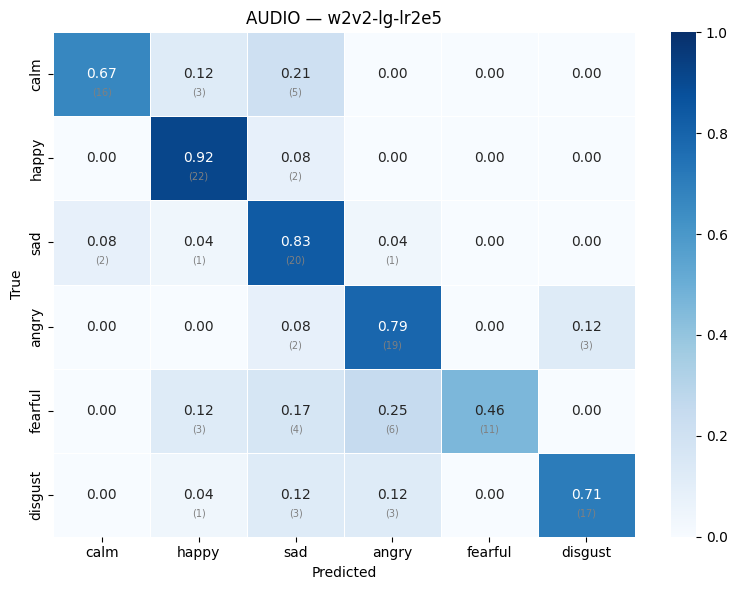

In [11]:
val_audio = EmotionDataset(METADATA, "val", "audio")
audio_loader = DataLoader(val_audio, batch_size=8, shuffle=False, collate_fn=collate_fn)

audio_cfg = next(e for e in EXPERIMENTS if e["name"] == best_audio["name"])
if "hubert" in best_audio["name"]:
    audio_model = HubertForSequenceClassification.from_pretrained(best_audio["path"]).to(DEVICE)
else:
    audio_model = Wav2Vec2ForSequenceClassification.from_pretrained(best_audio["path"]).to(DEVICE)
audio_processor = Wav2Vec2FeatureExtractor.from_pretrained(best_audio["path"])
audio_prep = partial(prepare_audio, processor=audio_processor,
                     window_s=audio_cfg.get("window_s", 3.0), device=DEVICE)

print(f"Evaluating: {best_audio['name']} (F1={best_audio['best_f1']:.4f})")
a_preds, a_labels, a_losses = collect_predictions(audio_model, audio_loader, audio_prep)
a_f1 = per_emotion_report(a_preds, a_labels, a_losses, f"AUDIO — {best_audio['name']}")

del audio_model
torch.cuda.empty_cache()

Evaluating: tsf-lr3e5-16f-nf (F1=0.7283)

  VIDEO — tsf-lr3e5-16f-nf

              precision    recall  f1-score   support

        calm      0.765     0.542     0.634        24
       happy      0.870     0.833     0.851        24
         sad      0.667     0.583     0.622        24
       angry      0.800     1.000     0.889        24
     fearful      0.700     0.583     0.636        24
     disgust      0.636     0.875     0.737        24

    accuracy                          0.736       144
   macro avg      0.740     0.736     0.728       144
weighted avg      0.740     0.736     0.728       144

Emotion          N    Acc     F1  AvgLoss
----------------------------------------
calm            24  0.542  0.634    1.545
happy           24  0.833  0.851    0.752
sad             24  0.583  0.622    1.507
angry           24  1.000  0.889    0.149
fearful         24  0.583  0.636    1.208
disgust         24  0.875  0.737    0.423

Weakest: sad (0.622) < calm (0.634) < fearful (0.63

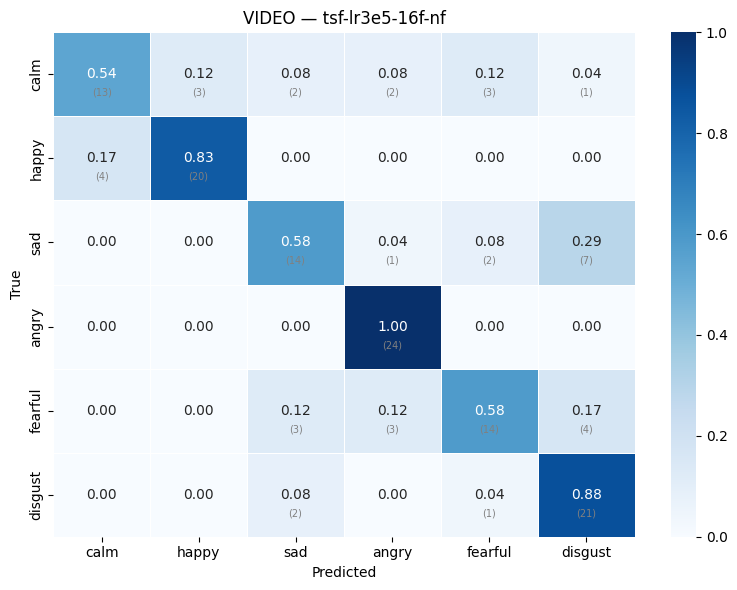

In [12]:
val_video = EmotionDataset(METADATA, "val", "video")
video_loader = DataLoader(val_video, batch_size=2, shuffle=False, collate_fn=collate_fn)

video_cfg = next(e for e in EXPERIMENTS if e["name"] == best_video["name"])
video_model = TimesformerForVideoClassification.from_pretrained(best_video["path"]).to(DEVICE)
video_processor = AutoImageProcessor.from_pretrained(best_video["path"])
video_prep = partial(prepare_video, processor=video_processor,
                     n_frames=video_cfg.get("n_frames", 16), device=DEVICE)

print(f"Evaluating: {best_video['name']} (F1={best_video['best_f1']:.4f})")
v_preds, v_labels, v_losses = collect_predictions(video_model, video_loader, video_prep)
v_f1 = per_emotion_report(v_preds, v_labels, v_losses, f"VIDEO — {best_video['name']}")

del video_model
torch.cuda.empty_cache()

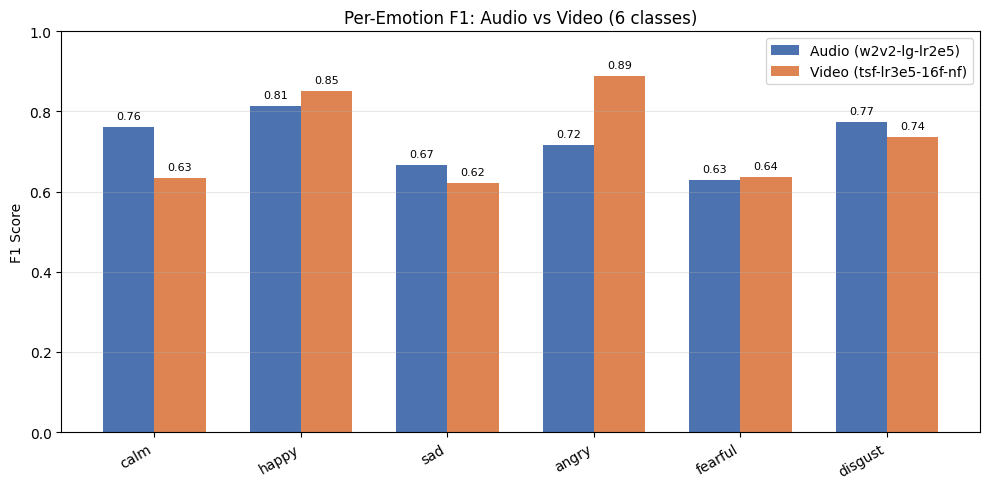


CROSS-MODAL GAPS
Emotion       Audio F1  Video F1     Gap
------------------------------------------
calm             0.762     0.634   0.128 (A)
happy            0.815     0.851   0.036 (V)
sad              0.667     0.622   0.044 (A)
angry            0.717     0.889   0.172 (V)
fearful          0.629     0.636   0.008 (V)
disgust          0.773     0.737   0.036 (A)

Overall weighted F1 — Audio: 0.7269, Video: 0.7283


In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(NUM_EMOTIONS)
w = 0.35

ax.bar(x - w/2, a_f1, w, label=f"Audio ({best_audio['name']})", color="#4C72B0")
ax.bar(x + w/2, v_f1, w, label=f"Video ({best_video['name']})", color="#DD8452")
ax.set_xticks(x)
ax.set_xticklabels(EMOTIONS, rotation=30, ha="right")
ax.set_ylabel("F1 Score")
ax.set_title("Per-Emotion F1: Audio vs Video (6 classes)")
ax.set_ylim(0, 1)
ax.legend()
ax.grid(axis="y", alpha=0.3)
for i in x:
    ax.text(i - w/2, a_f1[i] + 0.02, f"{a_f1[i]:.2f}", ha="center", fontsize=8)
    ax.text(i + w/2, v_f1[i] + 0.02, f"{v_f1[i]:.2f}", ha="center", fontsize=8)
plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print("CROSS-MODAL GAPS")
print(f"{'='*60}")
print(f"{'Emotion':<12s} {'Audio F1':>9s} {'Video F1':>9s} {'Gap':>7s}")
print("-" * 42)
for i, emo in enumerate(EMOTIONS):
    gap = abs(a_f1[i] - v_f1[i])
    better = "A" if a_f1[i] > v_f1[i] else "V"
    print(f"{emo:<12s} {a_f1[i]:9.3f} {v_f1[i]:9.3f} {gap:7.3f} ({better})")

overall_a = f1_score(a_labels, a_preds, average="weighted")
overall_v = f1_score(v_labels, v_preds, average="weighted")
print(f"\nOverall weighted F1 — Audio: {overall_a:.4f}, Video: {overall_v:.4f}")

In [14]:
torch.cuda.empty_cache()
gc.collect()
print("GPU RAM cleaned.")

GPU RAM cleaned.
